ChEn-3170: Computational Methods in Chemical Engineering Fall 2020 UMass Lowell; Prof. V. F. de Almeida **09Nov20**

# 13. Non-Linear Equation Root Finding w/ Newton's Method
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents <a id="toc"></a>
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data 1](#data1)
 - [Plot Root Function](#prf1)
 - [Plot Root 1](#prf11)
 - [Plot Root 2](#prf12)
* [Input Data 2](#data2)
 - [Plot Root Function](#prf2)
 - [Plot Root 1](#prf21)
* [Inverse Problem (Forensics and/or Reverse Engineering)](#inv)
---

## [Introduction](#toc)<a id="intro"></a>
Newton's method for computing roots of a single non-linear equation, $f(x)=0$, arising from chemical reaction equilibrium is described in the course notes OneNote [ChEn-3170-nonlinalg-a](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EsURG6azFKdHg13aiJdg0X8Bwn1JHj9ziyIz3bXrr2CjRw?e=P2EkeB). The reaction

\begin{equation*}
\text{A} + \text{B} \overset{K_x}{\longleftrightarrow} \text{C}   ,
\end{equation*}

is used as a model, that is, compute $x_A$, $x_B$, $x_C$ for the given stoichiometry and molar equilibrium reaction constant $K_x$, where 

\begin{equation*}
K_x = \frac{x_C}{x_A\,x_B}.
\end{equation*}


Note that this information is not sufficient for computing the equilibrium molar fraction. In addition, it is required that the molar fraction of **any two species is known** at some point in time or as a reference, say $x_{A_0}$, and $x_{B_0}$; note $x_{A_0} + x_{B_0} + x_{C_0} = 1$.

The normalized extent of reaction, $\widehat{\varepsilon}$, at equilibrium, satisfies the equilibrium condition

\begin{equation*}
\bigl(K_x+1\bigr) {\widehat{\varepsilon}}^2  - 
\bigl(1-x_{C_0}\bigr) \bigl(K_x+1\bigr) \widehat{\varepsilon} + x_{A_0}\,x_{B_0}\,K_x - x_{C_0} = 0 ,
\end{equation*}

*for this particular stoichiometry*. Therefore this can be casted as $f_\text{eq} (\widehat{\varepsilon}) = 0$, which is the form we need to use Newton's method on, thus 

\begin{equation*}
f_\text{eq} (\widehat{\varepsilon}) = 
\bigl(K_x+1\bigr) {\widehat{\varepsilon}}^2  - 
\bigl(1-x_{C_0}\bigr) \bigl(K_x+1\bigr) \widehat{\varepsilon} + x_{A_0}\,x_{B_0}\,K_x - x_{C_0} = 0 .
\end{equation*}

Note that if the stoichiometry changes, this function will be different.

Once the values of $\widehat{\varepsilon}$ are found, the equilibrium molar fractions are computed from

\begin{equation*}
x_A = \frac{x_{A_0} - \widehat{\varepsilon}}{1 - \widehat{\varepsilon}} \ \qquad  ; \qquad \
x_B = \frac{x_{B_0} - \widehat{\varepsilon}}{1 - \widehat{\varepsilon}} \ \qquad  ; \qquad \
x_C = \frac{x_{C_0} + \widehat{\varepsilon}}{1 - \widehat{\varepsilon}}.
\end{equation*}

Note the bounds on the normalized extent of reaction: $-x_{C_0} \le \widehat{\varepsilon} \le \min(x_{A_0},x_{B_0})$, showing that the extent of reaction can be either positive (forward reaction) or negative (reverse reaction).

In [1]:
'''Equilibrium function at values or array values'''

def f_eq(ext_hat, x_a_0, x_b_0, x_c_0, eq_kx_cte):
    '''
    Root function f(ext_hat) for A + B <=> C.

    Parameters
    ----------
    ext_hat: float or numpy.ndarray, required
        Normalized extent of reaction. If `ext_hat` is an array, 
        the return value is also an array of values.
    x_a_0: float, required
        Mole fraction of species A.
    x_b_0: float, required
        Mole fraction of species B.
    x_c_0: float, required
        Mole fraction of species B.
    eq_kx_cte: float, required
        Mole equilibrium reaction constant.
    
    Returns
    -------
    value: float or numpy.ndarray
        Value or array of values of the equilibrium function 
        evaluated at `ext_hat`.

    Examples
    --------
    '''
    assert x_a_0 >= 0. and x_b_0 >= 0. and x_b_0 >= 0.
    assert abs(x_a_0 + x_b_0 + x_c_0 - 1.0) <= 1e-12
           
    value =   (eq_kx_cte+1)*ext_hat**2  \
            - (1-x_c_0)*(eq_kx_cte+1)*ext_hat \
            + x_a_0 * x_b_0 * eq_kx_cte - x_c_0
        
    return value

In [2]:
'''Equilibrium function derivative'''

def f_eq_prime(ext_hat, x_c_0, eq_kx_cte):
    '''
    Derivative of equilibrium function f'(ext_hat) for A + B <=> C.

    Parameters
    ----------
    ext_hat: float or numpy.ndarray, required
        Normalized extent of reaction
    x_c_0: float, required
        Mole fraction of species B
    eq_kx_cte: float, required
        Mole equilibrium reaction constant.
    
    Returns
    -------
    value: float or numpy.ndarray
        Value or values of the root function evaluated at `ext_hat`.

    Examples
    --------
    '''
    # f_eq = (eq_kx_cte+1)*ext_hat**2 - (1-x_c_0)*(eq_kx_cte+1)*ext_hat + x_a_0 * x_b_0 * eq_kx_cte - x_c_0       
    value = 2.0*(eq_kx_cte+1)*ext_hat - (1-x_c_0)*(eq_kx_cte+1)
        
    return value

## [Algorithm](#toc)<a id="algo"></a>

Given $f(\cdot)$, find the roots 

\begin{equation*}
f(\widehat{\varepsilon}) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\varepsilon}_0$. Compute the updates

\begin{equation*}
\delta \widehat{\varepsilon}_k = - \frac{f(\widehat{\varepsilon}_{k-1})}{f'(\widehat{\varepsilon}_{k-1})} \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\varepsilon}_k = \widehat{\varepsilon}_{k-1} + \delta \widehat{\varepsilon}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\abs{\delta \widehat{\varepsilon}_k} \le 10^{-8}$ and $\abs{f(\widehat{\varepsilon}_k)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [3]:
'''Newton's method'''

def newton_solve(x_a_0, x_b_0, x_c_0, eq_kx_cte,
                  ext_hat_0=0.0, k_max=30, tolerance=1.0e-10, verbose=True ):

    # Other initialization
    delta_k = 1e+10
    f_k     = 1e+10
    ext_hat = ext_hat_0

    if verbose is True:
        print('\n')
        print('******************************************************')
        print("          Newton's Method Iterations                  ")
        print('******************************************************')
        print("k |  f(e_k)  |  f'(e_k) | |del e_k| |    e_k   |convg|")
        print('------------------------------------------------------')

    import math
    
    k = 0
    
    while (abs(delta_k) > tolerance or abs(f_k) > tolerance) and k <= k_max:
        
        f_k       = f_eq( ext_hat, x_a_0, x_b_0, x_c_0, eq_kx_cte )
        
        f_prime_k = f_eq_prime( ext_hat, x_c_0, eq_kx_cte )
        
        delta_k_old = delta_k
        
        delta_k = -f_k / f_prime_k # Newton's update
        
        ext_hat += delta_k
        
        if k > 0:
            if delta_k != 0.0 and delta_k_old != 0.0:
                convergence_factor = math.log(abs(delta_k),10) / math.log(abs(delta_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f'%\
                  (k,f_k,f_prime_k,abs(delta_k),ext_hat,convergence_factor))
            
    # Exit the while loop here
    if verbose is True:
        print('******************************************************') 
        print('Root = %8.5e'%ext_hat)
    
    return ext_hat

## [Input Data 1](#toc)<a id="data1"></a>

Reversible reaction: 
$\text{A} + \text{B} \overset{K_x}{\longleftrightarrow} \text{C}$

Name                        | Parameter    | Value |
----------------------------|--------------|-------| 
initial mole fraction of A  | $x_{A_0}$    | 0.5   | 
initial mole fraction of B  | $x_{B_0}$    | 0.5   |
initial mole fraction of C  | $x_{C_0}$    | 0.0   |
mole equilibrium constant   | $K_\text{x}$ | 108   | 

In [4]:
'''Parameters for chemical equilibrium of A + B <-> C'''

x_a_0 = 0.5 # initial (or ref) equimolar
x_b_0 = 0.5 # initial (or ref) equimolar
x_c_0 = 0.0 # initial (or ref) no product

assert abs(x_a_0 + x_b_0 + x_c_0 - 1.0) <= 1e-12
assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.

eq_kx_cte = 108.0

print('Min. ext_hat = %5.2f'%(-x_c_0))
print('Max. ext_hat = %5.2f'%min(x_a_0,x_b_0))

Min. ext_hat = -0.00
Max. ext_hat =  0.50


In [5]:
'''Function: plot equilibrium function'''

def plot_function( ex_min, ex_max, n_pts,
                   x_a_0, x_b_0, x_c_0, eq_kx_cte,
                   ext_hat_root=None  ):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    plt.figure(1, figsize=(8, 6))
    
    import numpy as np
    ex_vec = np.linspace(ex_min, ex_max, n_pts)
    
    plt.plot(ex_vec, f_eq(ex_vec, x_a_0, x_b_0, x_c_0, eq_kx_cte),'b-',label='$f_{eq}$')
    
    plt.xlabel(r'$\hat{\varepsilon}$',fontsize=18)
    plt.ylabel(r'$f_{eq}(\hat{\varepsilon})$',fontsize=18)
    plt.title('Computing the Roots of $f(x)$',fontsize=20)
    plt.legend(loc='best',fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    (x_min,x_max) = plt.xlim()
    dx = abs(x_max-x_min)
    x_text = (x_max+x_min)/2
    
    (y_min,y_max) = plt.ylim()
    dy = abs(y_max-y_min)
    y_text = y_max - dy*0.05
    
    plt.text(x_text, y_text, r'$x_{A_0}=$%8.2e'%x_a_0,fontsize=16)
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$x_{B_0}=$%8.2e'%x_b_0,fontsize=16)
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$x_{C_0}=$%8.2e'%x_c_0,fontsize=16)
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$K_x=$%8.2e'%eq_kx_cte,fontsize=16)
    
    
    if ext_hat_root is not None:
        
        plt.plot(ext_hat_root, 0.0,'r*',label='root',markersize=14)
               
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = ext_hat_root + dx*0.01
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = 0.0 + dy*0.01
    
        plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%ext_hat_root,fontsize=16)
    
    
    plt.grid(True)
    plt.show()
    print('')
    
    return

### [Plot Root Function](#toc)<a id="prf1"></a>

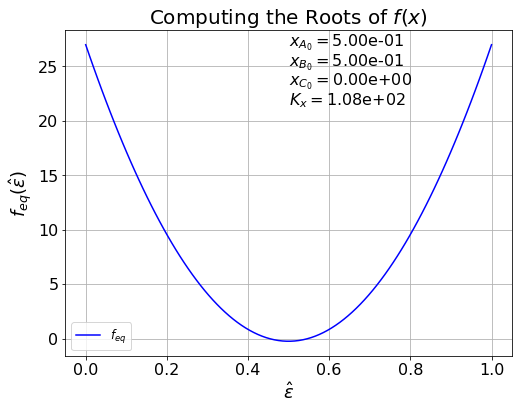

In [6]:
'''Plot equilibrium function'''

ext_hat_min = 0.0
ext_hat_max = 1.0

n_pts = 100

plot_function( ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte )

In [7]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.0    # initial guess
k_max = 20         # maximum # of Newton iterations
tolerance = 1.0e-8 # convergence tolerance

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0, k_max, tolerance)

x_a = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c = (x_c_0 + ext_hat)/(1.0-ext_hat)

assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.
assert abs(x_a + x_b + x_c - 1.0) <= 1e-12
assert abs(x_c/x_a/x_b - eq_kx_cte) <= 1e-10,'%r'%(abs(x_c/x_a/x_b - eq_kx_cte))

print('')
print('Equilibrium mole fractions:\n')
print('x_a = %5.3e (%4.1f%%)'%(x_a,round(x_a*100,1)))
print('x_b = %5.3e (%4.1f%%)'%(x_b,round(x_b*100,1)))
print('x_c = %5.3e (%4.1f%%)'%(x_c,round(x_c*100,1)))



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  f(e_k)  |  f'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +2.700e+01 -1.090e+02 +2.477e-01  +2.477e-01  0.00
 2 +6.688e+00 -5.500e+01 +1.216e-01  +3.693e-01  1.51
 3 +1.612e+00 -2.849e+01 +5.657e-02  +4.259e-01  1.36
 4 +3.488e-01 -1.616e+01 +2.159e-02  +4.475e-01  1.34
 5 +5.080e-02 -1.145e+01 +4.436e-03  +4.519e-01  1.41
 6 +2.145e-03 -1.048e+01 +2.046e-04  +4.521e-01  1.57
 7 +4.561e-06 -1.044e+01 +4.369e-07  +4.521e-01  1.72
 8 +2.081e-11 -1.044e+01 +1.993e-12  +4.521e-01  1.84
******************************************************
Root = 4.52109e-01

Equilibrium mole fractions:

x_a = 8.741e-02 ( 8.7%)
x_b = 8.741e-02 ( 8.7%)
x_c = 8.252e-01 (82.5%)


### [Plot Root 1](#toc)<a id="prf11"></a>

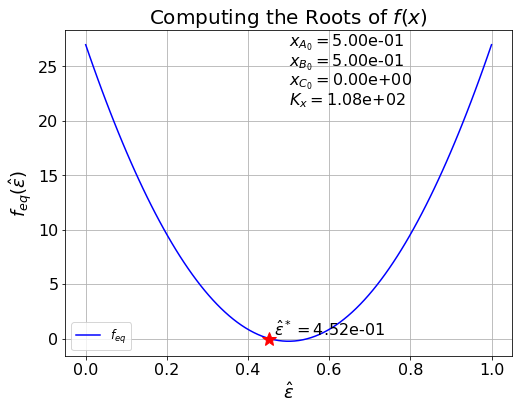

In [8]:
'''Plot equilibrium function with root'''

ext_hat_min = 0.0
ext_hat_max = 1.0

n_pts = 100

plot_function(ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte, ext_hat)

In [9]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.7 # not valid; we know in advance but let's do it anyway
k_max = 20

tolerance = 1.0e-8

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )

x_a = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c = (x_c_0 + ext_hat)/(1.0-ext_hat)

#assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.
assert abs(x_a + x_b + x_c - 1.0) <= 1e-12
assert abs(x_c/x_a/x_b - eq_kx_cte) <= 1e-10,'%r'%(abs(x_c/x_a/x_b - eq_kx_cte))

print('')
print('Equilibrium mole fractions:\n')
print('x_a = %5.3e\n'%x_a)
print('x_b = %5.3e\n'%x_a)
print('x_c = %5.3e\n'%x_c)



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  f(e_k)  |  f'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +4.110e+00 +4.360e+01 +9.427e-02  +6.057e-01  0.00
 2 +9.686e-01 +2.305e+01 +4.202e-02  +5.637e-01  1.34
 3 +1.925e-01 +1.389e+01 +1.386e-02  +5.499e-01  1.35
 4 +2.093e-02 +1.087e+01 +1.926e-03  +5.479e-01  1.46
 5 +4.042e-04 +1.045e+01 +3.869e-05  +5.479e-01  1.62
 6 +1.631e-07 +1.044e+01 +1.563e-08  +5.479e-01  1.77
 7 +2.132e-14 +1.044e+01 +2.042e-15  +5.479e-01  1.88
******************************************************
Root = 5.47891e-01

Equilibrium mole fractions:

x_a = -1.059e-01

x_b = -1.059e-01

x_c = 1.212e+00



### [Plot Root 2](#toc)<a id="prf12"></a>

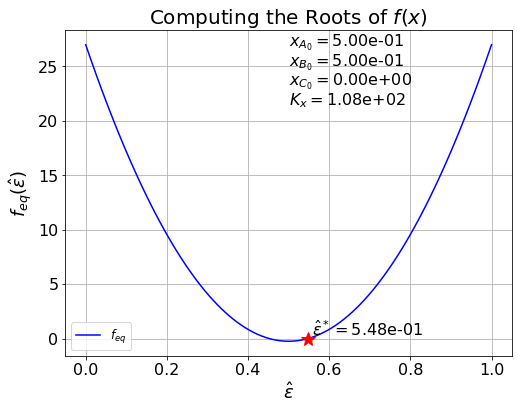

In [10]:
'''Plot equilibrium function with root'''

ext_hat_min = 0.0
ext_hat_max = 1.0

n_pts = 100

plot_function( ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte, ext_hat )

In [11]:
'''Find root at the root'''

ext_hat_0 = ext_hat
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  f(e_k)  |  f'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +0.000e+00 +1.044e+01 +0.000e+00  +5.479e-01  0.00
******************************************************
Root = 5.47891e-01


## [Input Data 2](#toc)<a id="data2"></a>

Reversible reaction: A + B <=> C 

Name                        | Parameter    | Value    |
----------------------------|--------------|----------| 
initial mole fraction of A  | $x_{A0}$     | 0.5      |
initial mole fraction of B  | $x_{B0}$     | 0.2      |
initial mole fraction of C  | $x_{C0}$     | 0.3      |
mole equilibrium constant   | $K_\text{x}$ | 108      |

In [12]:
'''Parameters for chemical equilibrium of A + B <-> C'''

x_a_0 = 0.5 # initial (or ref)
x_b_0 = 0.2 # initial (or ref)
x_c_0 = 0.3 # initial (or ref)

assert abs(x_a_0 + x_b_0 + x_c_0 - 1.0) <= 1e-12
assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.

eq_kx_cte = 108.0

print('Min. ext_hat = %5.2f'%(-x_c_0))
print('Max. ext_hat = %5.2f'%min(x_a_0,x_b_0))

Min. ext_hat = -0.30
Max. ext_hat =  0.20


### [Plot Root Function](#toc)<a id="prf2"></a>

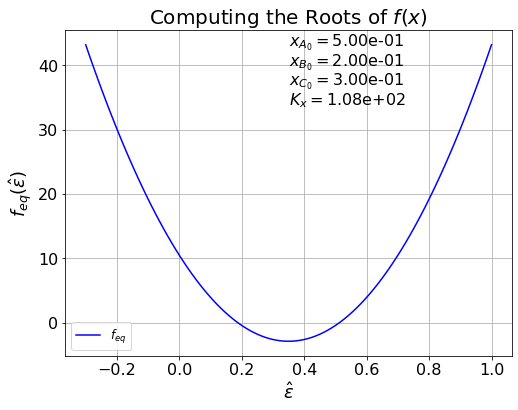

In [13]:
'''Plot equilibrium function'''

ext_hat_min = -x_c_0
ext_hat_max = 1.0
n_pts = 100
plot_function( ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte )

In [14]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )

x_a = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c = (x_c_0 + ext_hat)/(1.0-ext_hat)

assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.
assert abs(x_a + x_b + x_c - 1.0) <= 1e-12
assert abs(x_c/x_a/x_b - eq_kx_cte) <= 1e-10,'%r'%(abs(x_c/x_a/x_b - eq_kx_cte))

print('')
print('Equilibrium mole fractions:\n')
print('x_a = %5.3e\n'%x_a)
print('x_b = %5.3e\n'%x_b)
print('x_c = %5.3e\n'%x_c)



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  f(e_k)  |  f'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.050e+01 -7.630e+01 +1.376e-01  +1.376e-01  0.00
 2 +2.064e+00 -4.630e+01 +4.458e-02  +1.822e-01  1.57
 3 +2.167e-01 -3.658e+01 +5.923e-03  +1.881e-01  1.65
 4 +3.824e-03 -3.529e+01 +1.083e-04  +1.882e-01  1.78
 5 +1.280e-06 -3.527e+01 +3.628e-08  +1.882e-01  1.88
 6 +1.446e-13 -3.527e+01 +4.100e-15  +1.882e-01  1.93
******************************************************
Root = 1.88229e-01

Equilibrium mole fractions:

x_a = 3.841e-01

x_b = 1.450e-02

x_c = 6.014e-01



### [Plot Root 1](#toc)<a id="prf21"></a>

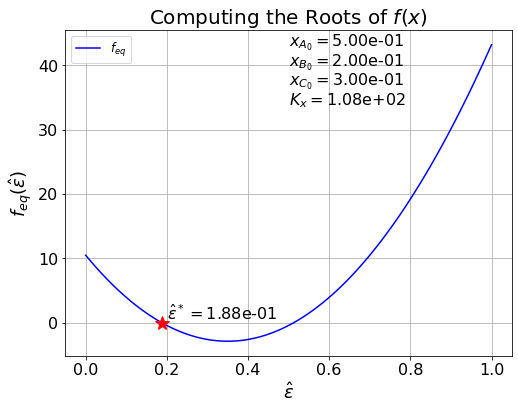

In [15]:
'''Plot equilibrium function with root'''

ext_hat_min = 0.0
ext_hat_max = 1.0

n_pts = 100

plot_function( ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte, ext_hat )

## [Inverse Problem (Forensics and Reverse Engineering)](#toc)<a id="inv"></a>
Someone is interested in the answers to the questions:

1. If we know equilibrium molar fractions $x_A$, $x_B$ and $x_C$, could a unique initial (reference) $x_{A_0} , x_{B_0}, x_{C_0}$ be computed? if not unique, how many exist?
2. What could we say about the initial (reference)  values $x_{A_0} , x_{B_0}, x_{C_0}$?

In [ ]:
'''Let us compute an equilibrium molar fraction'''

x_a_0 = 0.34
x_b_0 = 0.64
x_c_0 = 0.02

assert abs(x_a_0 + x_b_0 + x_c_0 - 1.0) <= 1e-12
assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.

eq_kx_cte = 56.8 #108.0

print('Min. ext_hat = %5.2f'%(-x_c_0))
print('Max. ext_hat = %5.2f'%min(x_a_0,x_b_0))

In [ ]:
'''Find root and the "gold" equilibrium molar fractions'''

ext_hat_0 = 0.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )

x_a_gold = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b_gold = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c_gold = (x_c_0 + ext_hat)/(1.0-ext_hat)

assert x_a_gold > 0. and x_b_gold > 0. and x_c_gold >= 0.
assert abs(x_a_gold + x_b_gold + x_c_gold - 1.0) <= 1e-12
assert abs(x_c_gold/x_a_gold/x_b_gold - eq_kx_cte) <= 1e-12,'%r'%(abs(x_c_gold/x_a_gold/x_b_gold - eq_kx_cte)) 

print('')
print('Equilibrium mole fractions:\n')
print('x_a_gold = %5.3e\n'%x_a_gold)
print('x_b_gold = %5.3e\n'%x_b_gold)
print('x_c_gold = %5.3e\n'%x_c_gold)

In [ ]:
'''Find the reference molar fractions'''

try:
    from chen_3170.toolkit import magic_molar_fractions
except ModuleNotFoundError:
    assert False, 'You need to provide your own magic_molar_fractions function here. Bailing out.'

# this magic function returns reference molar fractions for given equilibrium molar fractions
(x_a_0,x_b_0,x_c_0) = magic_molar_fractions( x_a_gold, x_b_gold, x_c_gold )

print('x_A_0 = %5.3e\n'%x_a_0)
print('x_B_0 = %5.3e\n'%x_b_0)
print('x_C_0 = %5.3e\n'%x_c_0)

assert abs(x_a_0 + x_b_0 + x_c_0 - 1.0) <= 1e-12
assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.

print('Min. ext_hat = %5.2f'%(-x_c_0))
print('Max. ext_hat = %5.2f'%min(x_a_0,x_b_0))

In [ ]:
'''Plot equilibrium function'''

ext_hat_min = 0.0
ext_hat_max = 1.0
n_pts = 100
plot_function( ext_hat_min, ext_hat_max, n_pts, x_a_0, x_b_0, x_c_0, eq_kx_cte )

In [ ]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )

x_a = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c = (x_c_0 + ext_hat)/(1.0-ext_hat)

assert x_a_0 >= 0. and x_b_0 >= 0. and x_c_0 >= 0.
assert abs(x_a + x_b + x_c - 1.0) <= 1e-12
assert abs(x_c/x_a/x_b - eq_kx_cte) <= 1e-10,'%r'%(abs(x_c/x_a/x_b - eq_kx_cte))

print('')
print('Equilibrium mole fractions:\n')
print('x_a = %5.3e\n'%x_a)
print('x_b = %5.3e\n'%x_b)
print('x_c = %5.3e\n'%x_c)

assert abs(x_a-x_a_gold) + abs(x_b-x_b_gold) + abs(x_c-x_c_gold) <= 1e-12

In [ ]:
'''Function: reference states'''

def plot_ref_states( x_a_0, x_b_0, x_c_0,
                     x_a, x_b, x_c ):
    
    import matplotlib.pyplot as plt
    
    plt.figure(1, figsize=(15, 6))
    
    plt.subplot(121) 
    
    plt.plot(x_a_0, x_b_0,'b*',markersize=14)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel(r'$x_{A_0}$',fontsize=18)
    plt.ylabel(r'$x_{B_0}$',fontsize=18)
    plt.title('Reference',fontsize=20)   
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    plt.subplot(122)
    plt.plot(x_a, x_b,'go',markersize=14)
    
    plt.xlim(0,1)
    plt.ylim(0,1)  
    plt.xlabel(r'$x_{A}$',fontsize=18)
    plt.ylabel(r'$x_{B}$',fontsize=18)
    plt.title('Gold Equilibrium',fontsize=20)  
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    plt.show()
    print('')
    
    return

In [ ]:
'''Plot reference state'''

plot_ref_states( x_a_0, x_b_0, x_c_0, x_a_gold, x_b_gold, x_c_gold )

In [ ]:
'''Let us do this one more time'''

import numpy as np
x_0 = np.zeros((3,2))

x_0[:,0] = np.array([x_a_0,x_b_0,x_c_0]) # save previous reference molar fractions

(x_a_0,x_b_0,x_c_0) = magic_molar_fractions( x_a_gold, x_b_gold, x_c_gold )

ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                        ext_hat_0,k_max,tolerance )

x_a = (x_a_0 - ext_hat)/(1.0-ext_hat)
x_b = (x_b_0 - ext_hat)/(1.0-ext_hat)
x_c = (x_c_0 + ext_hat)/(1.0-ext_hat)

assert abs(x_a-x_a_gold) + abs(x_b-x_b_gold) + abs(x_c-x_c_gold) <= 1e-12

x_0[:,1] = np.array([x_a_0,x_b_0,x_c_0])

plot_ref_states( x_0[0,:], x_0[1,:], x_0[2,:], x_a_gold, x_b_gold, x_c_gold )

**Could a unique $x_{A_0} , x_{B_0}, x_{C_0}$ be computed?** <br>
**If not unique, how many exist?** <br>

**So is it hopeless? or can we say something about the reference molar fractions?**

In [ ]:
'''Plot reference states'''

npts = 500

import numpy as np
x_0  = np.zeros((3,npts))
x_eq = np.zeros((3,npts))

for i in range(npts):
    
    (x_a_0,x_b_0,x_c_0) = magic_molar_fractions( x_a_gold, x_b_gold, x_c_gold )
    
    x_0[0,i] = x_a_0
    x_0[1,i] = x_b_0
    x_0[2,i] = x_c_0
    
    ext_hat = newton_solve( x_a_0, x_b_0, x_c_0, eq_kx_cte,
                            ext_hat_0,k_max, tolerance, verbose=False )
    
    x_eq[0,i] = (x_a_0 - ext_hat)/(1.0-ext_hat)
    x_eq[1,i] = (x_b_0 - ext_hat)/(1.0-ext_hat)
    x_eq[2,i] = (x_c_0 + ext_hat)/(1.0-ext_hat)
    
plot_ref_states( x_0[0,:], x_0[1,:], x_0[2,:], x_eq[0,:], x_eq[1,:], x_eq[2,:] )